# E-Commerce Data Science Portfolio

## Market Basket analysis

### Step 1: import everything needed

In [31]:
import pandas as pd #working with data tables + CSVs
import numpy as np # working with arrays and arrays.
import matplotlib.pyplot as plt # for charts
from mlxtend.frequent_patterns import apriori # ml for -only- freq itemsets
from mlxtend.preprocessing import TransactionEncoder # for preparation transaction data for apriori algorithm

In [32]:
print("The three datasets loaded:")

order_items = pd.read_csv("../data/olist_order_items_dataset.csv") #what products
products = pd.read_csv("../data/olist_products_dataset.csv") # product details + category 
orders = pd.read_csv("../data/olist_orders_dataset.csv") # order info + dates

# show num of rows in each of the datasets
print(f"Order items: {len(order_items)} rows")
print(f"Products: {len(products)} rows")
print(f"Orders: {len(orders)} rows")

# show first couple of rows for each:
print("First few order items:")
print(order_items[['order_id', 'product_id', 'order_item_id']].head(5))

The three datasets loaded:
Order items: 112650 rows
Products: 32951 rows
Orders: 99441 rows
First few order items:
                           order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

   order_item_id  
0              1  
1              1  
2              1  
3              1  
4              1  


###  Step 2: Merge & Prepare the data for analysis

In [33]:
print("Prepare the data for market basket analysis (MBA)")

# Merge order items with product categories to see what type of products were bought.
order_items_with_categories = pd.merge(order_items, products[['product_id', 'product_category_name']], 
                                       on='product_id', how='left')


print(" The data after adding product categories:\n")
# show the first 10 items:
print(order_items_with_categories[['order_id', 'product_id', 'product_category_name']].head(10))

# Check how many orders have multiple items
print("\n")
order_sizes = order_items_with_categories.groupby('order_id').size()
# filter only > 1 items per order
multi_item_orders = order_sizes[order_sizes > 1]

print(f"Orders with multiple items: {len(multi_item_orders)}")
print(f"Percentage of orders with multiple items: {(len(multi_item_orders) / len(order_sizes) * 100):.1f}%")

Prepare the data for market basket analysis (MBA)
 The data after adding product categories:

                           order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   
5  00048cc3ae777c65dbb7d2a0634bc1ea  ef92defde845ab8450f9d70c526ef70f   
6  00054e8431b9d7675808bcb819fb4a32  8d4f2bb7e93e6710a28f34fa83ee7d28   
7  000576fe39319847cbb9d288c5617fa6  557d850972a7d6f792fd18ae1400d9b6   
8  0005a1a1728c9d785b8e2b08b904576c  310ae3c140ff94b03219ad0adc3c778f   
9  0005f50442cb953dcd1d21e1fb923495  4535b0e1091c278dfd193e5a1d63b39f   

   product_category_name  
0             cool_stuff  
1               pet_shop  
2       moveis_decora

### Step 3: Create transaction data

In [34]:
# Group items by order to see what was bought together
print("The transaction data:\n")
transactions = order_items_with_categories.groupby('order_id')['product_category_name'].apply(list).reset_index()

print(f"Total transactions: {len(transactions)}")
print(f"Transactions with multiple items: {len(transactions[transactions['product_category_name'].apply(len) > 1])}")

# Show examples of orders with multiple items
print("Sample transactions with multiple items:")
for i in range(min(5, len(transactions))):
    items = transactions.iloc[i]['product_category_name']
    if len(items) > 1:
        print(f"Order: {items}")

# note: no product associations ->> most buy single items only 5 in first of the 9803 transactions.

The transaction data:

Total transactions: 98666
Transactions with multiple items: 9803
Sample transactions with multiple items:


### Step 4: Prepare the data for the Apriori algorithm

In [40]:
# First check for and handle missing categories
print(f"\nMissing product categories: {transactions['product_category_name'].isnull().sum()}")

# Fill missing categories with a placeholder or remove them
transactions_clean = transactions.copy()
transactions_clean['product_category_name'] = transactions_clean['product_category_name'].apply(
    lambda x: [item for item in x if item is not None and pd.notna(item)] if isinstance(x, list) else x
)

# Remove transactions that ended up with no categories after cleaning
transactions_clean = transactions_clean[transactions_clean['product_category_name'].apply(len) > 0]

print(f"Transactions after cleaning: {len(transactions_clean)}")

# Convert the CLEAN transaction list to a format the algorithm can use
transaction_list = transactions_clean['product_category_name'].tolist()

# Create a binary matrix where each column is a product category -> needs this for apriori.
# 1 means the category was in the order, 0 means it wasn't
te = TransactionEncoder()
te_array = te.fit(transaction_list).transform(transaction_list)
transaction_df = pd.DataFrame(te_array, columns=te.columns_)

print(f"Transaction matrix shape: {transaction_df.shape}")
print(f"Number of unique product categories: {len(te.columns_)}")
print("First few rows of transaction matrix:\n")
print(transaction_df.iloc[:5, :8])  # Show first 5 transactions and first 8 categories


Missing product categories: 0
Transactions after cleaning: 97277
Transaction matrix shape: (97277, 73)
Number of unique product categories: 73
First few rows of transaction matrix:

   agro_industria_e_comercio  alimentos  alimentos_bebidas  artes  \
0                      False      False              False  False   
1                      False      False              False  False   
2                      False      False              False  False   
3                      False      False              False  False   
4                      False      False              False  False   

   artes_e_artesanato  artigos_de_festas  artigos_de_natal  audio  
0               False              False             False  False  
1               False              False             False  False  
2               False              False             False  False  
3               False              False             False  False  
4               False              False             False  Fa

### Step 5: Find frequent itemsets using Apriori algorithm

In [36]:
# Step 5: Find frequent itemsets using Apriori algorithm
print("Finding frequent product combinations...")

# The Apriori algorithm finds combinations of products that appear frequently together
# min_support=0.01 means we look for combinations that appear in at least 1% of orders
frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True, max_len=2)

print(f"Found {len(frequent_itemsets)} frequent product combinations")
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)

print("Top 10 most common product combinations:")
for i, row in frequent_itemsets.head(10).iterrows():
    items = list(row['itemsets'])
    support = row['support']
    print(f"  {items}: {support:.3f} (appears in {support*100:.1f}% of orders)")

Finding frequent product combinations...
Found 21 frequent product combinations
Top 10 most common product combinations:
  ['cama_mesa_banho']: 0.097 (appears in 9.7% of orders)
  ['beleza_saude']: 0.091 (appears in 9.1% of orders)
  ['esporte_lazer']: 0.079 (appears in 7.9% of orders)
  ['informatica_acessorios']: 0.069 (appears in 6.9% of orders)
  ['moveis_decoracao']: 0.066 (appears in 6.6% of orders)
  ['utilidades_domesticas']: 0.060 (appears in 6.0% of orders)
  ['relogios_presentes']: 0.058 (appears in 5.8% of orders)
  ['telefonia']: 0.043 (appears in 4.3% of orders)
  ['automotivo']: 0.040 (appears in 4.0% of orders)
  ['brinquedos']: 0.040 (appears in 4.0% of orders)


### Step 6: Generate association rules

In [37]:

print(f"Total frequent itemsets found: {len(frequent_itemsets)}")
# find atleast 2% of products can be 5%.
print(f"Frequent itemsets with support > 0.02: {len(frequent_itemsets[frequent_itemsets['support'] > 0.02])}")

print("\nTop 20 most frequent single categories:")

single_categories = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) == 1]
# filter to find only one category
for i, row in single_categories.head(20).iterrows():
    category = list(row['itemsets'])[0]
    support = row['support']
    print(f"  {category}: {support:.3f} ({support*100:.1f}% of orders)")

print("\nTop combinations of categories:")
# filter for mulit categories for orders -> obv for 2+ items order.
combo_categories = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) > 1]
if len(combo_categories) > 0:
    for i, row in combo_categories.head(10).iterrows():
        categories = list(row['itemsets'])
        support = row['support']
        print(f"  {categories}: {support:.3f} ({support*100:.1f}% of orders)")
else:
    print("  No category combinations found with significant frequency")

Total frequent itemsets found: 21
Frequent itemsets with support > 0.02: 16

Top 20 most frequent single categories:
  cama_mesa_banho: 0.097 (9.7% of orders)
  beleza_saude: 0.091 (9.1% of orders)
  esporte_lazer: 0.079 (7.9% of orders)
  informatica_acessorios: 0.069 (6.9% of orders)
  moveis_decoracao: 0.066 (6.6% of orders)
  utilidades_domesticas: 0.060 (6.0% of orders)
  relogios_presentes: 0.058 (5.8% of orders)
  telefonia: 0.043 (4.3% of orders)
  automotivo: 0.040 (4.0% of orders)
  brinquedos: 0.040 (4.0% of orders)
  cool_stuff: 0.037 (3.7% of orders)
  ferramentas_jardim: 0.036 (3.6% of orders)
  perfumaria: 0.033 (3.3% of orders)
  bebes: 0.030 (3.0% of orders)
  eletronicos: 0.026 (2.6% of orders)
  papelaria: 0.024 (2.4% of orders)
  fashion_bolsas_e_acessorios: 0.019 (1.9% of orders)
  pet_shop: 0.018 (1.8% of orders)
  moveis_escritorio: 0.013 (1.3% of orders)
  consoles_games: 0.011 (1.1% of orders)

Top combinations of categories:
  No category combinations found wi

### Step 7: Visualize what we actually found - single category popularity

Chart to show the most popular categories:


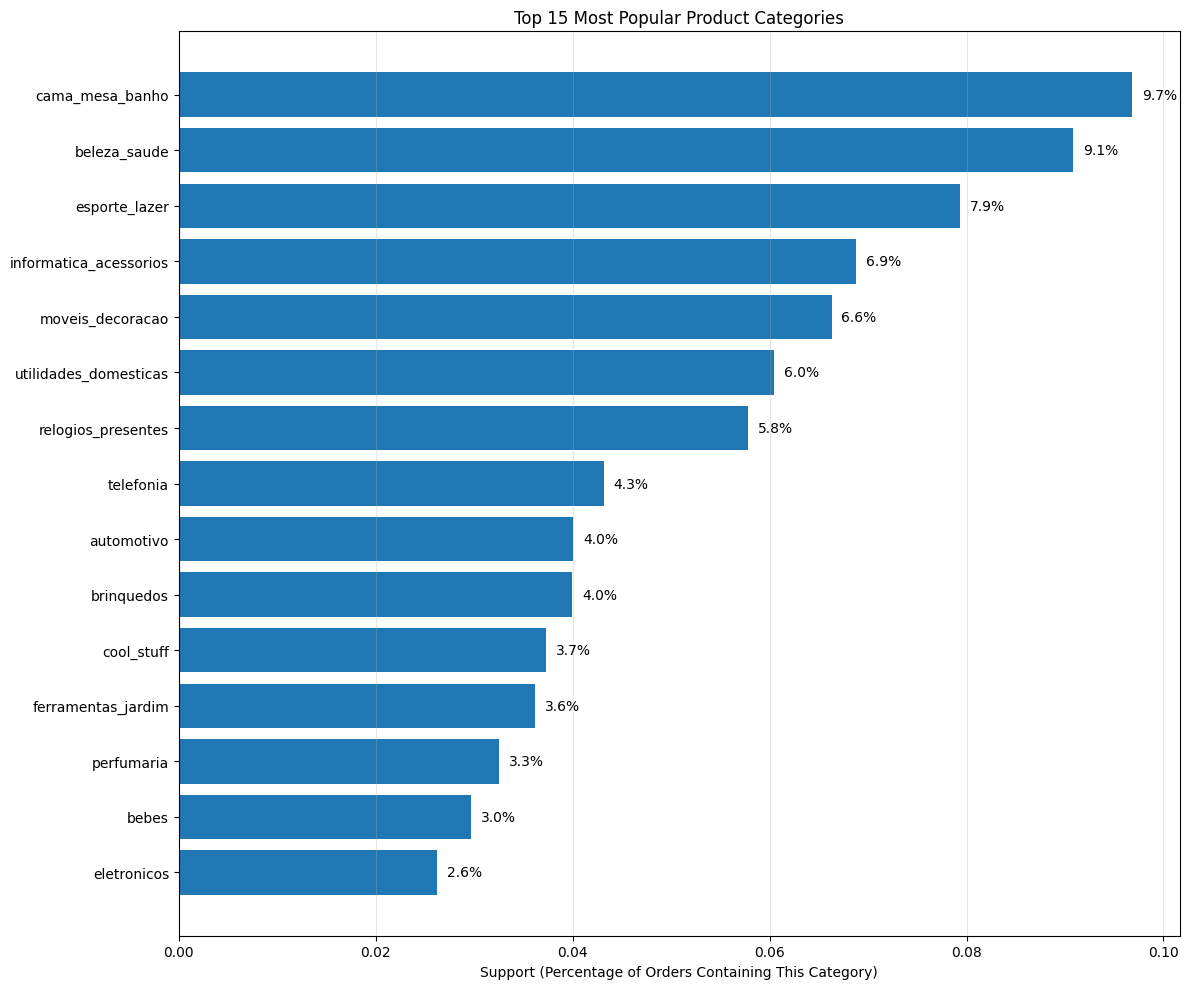

In [38]:
# from prev data only single category purchases.

# plot helps with understanding the customer purhcasing behaviour.
print("Chart to show the most popular categories:")

plt.figure(figsize=(12, 10)) # make chart to see the categories

# Create a bar chart of the top single categories
top_categories = single_categories.head(15).copy()
top_categories['category'] = top_categories['itemsets'].apply(lambda x: list(x)[0])

# Create horizontal (barh) bar chart of most popular categories
plt.barh(range(len(top_categories)), top_categories['support']) #easier to read over vertical
plt.yticks(range(len(top_categories)), top_categories['category']) #cat names instead of indices
plt.xlabel('Support (Percentage of Orders Containing This Category)') # support = % of items
plt.title('Top 15 Most Popular Product Categories')
plt.gca().invert_yaxis()  # Show highest support at top
plt.grid(axis='x', alpha=0.3) #grid lines.

# Add percentage labels to each bar of the bar chart
for i, v in enumerate(top_categories['support']):
    plt.text(v + 0.001, i, f'{v * 100:.1f}%', va='center')

plt.tight_layout() # keep it tight as it's big
plt.show()

## Conclusion

In [41]:

print("Conclusion - customers tend to just buy from the same categories:")

print("Based on the market basket analysis (MBA) that was done, here are the key findings:")

print("\n--> There are no strong cross-category associations detected")
print("--> Customers tend to just buy single category items.")

print("\nWhat does this means for the business:")
print("--> Customers tend to shop within one category per order")
print("--> When buying multiple items, they stick to related products")
print("--> Cross-category shopping patterns are rare and unpredictable")

print("\nTop 15 performing categories:")
top_cats = single_categories.head(15) # top 15 categories
for i, row in top_cats.iterrows():
    category = list(row['itemsets'])[0]
    support = row['support'] # turn then to % next line
    print(f"  - {category}: {support*100:.1f}% of orders")

# no association rules were genrated but still show it below:
rules = pd.DataFrame() # 0


print(f"\nSummary:")
print(f"- Found {len(rules)} meaningful product associations") # 0
print(f"- {len(frequent_itemsets)} frequent product combinations identified") 
print(f"- Analysis based on {len(transactions)} customer orders")
print(f"- {len(multi_item_orders)} orders contained multiple items")

print("\nIn conclusion here are the recommndations to take to up the sales:")
print("--> Definitely focus more DEEP category exploration -> more items within same category")
print("--> Create same category bundles rather than cross-category bundles")
print("--> Improve recommendations within categories, not across categories")
print("--> Improve advertising same category products like on TEMU -> customer who bought \n    this also path this")

Conclusion - customers tend to just buy from the same categories:
Based on the market basket analysis (MBA) that was done, here are the key findings:

--> There are no strong cross-category associations detected
--> Customers tend to just buy single category items.

What does this means for the business:
--> Customers tend to shop within one category per order
--> When buying multiple items, they stick to related products
--> Cross-category shopping patterns are rare and unpredictable

Top 15 performing categories:
  - cama_mesa_banho: 9.7% of orders
  - beleza_saude: 9.1% of orders
  - esporte_lazer: 7.9% of orders
  - informatica_acessorios: 6.9% of orders
  - moveis_decoracao: 6.6% of orders
  - utilidades_domesticas: 6.0% of orders
  - relogios_presentes: 5.8% of orders
  - telefonia: 4.3% of orders
  - automotivo: 4.0% of orders
  - brinquedos: 4.0% of orders
  - cool_stuff: 3.7% of orders
  - ferramentas_jardim: 3.6% of orders
  - perfumaria: 3.3% of orders
  - bebes: 3.0% of ord